In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy
from scipy.sparse import coo_matrix

In [2]:
## load .npy data
X = np.load('../data/X_example.npy',allow_pickle=True)
X.shape

(45, 100)

In [3]:
def reverse_patches(X, N, M):
    # Convert sparse matrix to dense for easier manipulation
    X_dense = X.toarray()
    
    # Get the dimensions of the matrix
    rows, cols = X_dense.shape
    
    # Calculate the number of patches along rows and columns
    num_patches_row = rows // N
    num_patches_col = cols // M
    
    # Create a list to hold the patches
    patches = []

    # Extract patches and store them in the list
    for i in range(num_patches_row):
        for j in range(num_patches_col):
            patch = X_dense[i*N:(i+1)*N, j*M:(j+1)*M]
            patches.append(patch)
    
    # Reverse the order of patches
    patches_reversed = patches[::-1]
    
    # Reconstruct the matrix from reversed patches
    reconstructed_rows = []
    for i in range(num_patches_row):
        row_patches = patches_reversed[i*num_patches_col:(i+1)*num_patches_col]
        reconstructed_row = np.hstack(row_patches)
        reconstructed_rows.append(reconstructed_row)
    
    X_reconstructed = np.vstack(reconstructed_rows)
    
    # Convert back to sparse format
    X_reconstructed_sparse = coo_matrix(X_reconstructed)
    
    return X_reconstructed_sparse

In [4]:
def construct_X(M, alphas, Np=None):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    if Np % 2 == 0:
        Np += 1

    # Coordinates of the tomogram's pixel centers, shifted so that the center pixel is at (0, 0)
    grid = np.mgrid[0:M, 0:M] - (M - 1) / 2
    C = np.vstack((grid[0].ravel(), grid[1].ravel()))

    D = M * M  # Number of pixels in the tomogram
    No = len(alphas)  # Number of projection angles
    N = No * Np  # Total number of sensor measurements
    
    # Initialize lists to collect the indices and weights of the non-zero elements in the sparse matrix
    i_indices = []
    j_indices = []
    weights = []

    # Sensor array's center coordinate
    s0 = (Np - 1) / 2

    for k, alpha in enumerate(alphas):
        # Convert angle from degrees to radians
        alpha_rad = np.deg2rad(alpha)
        # Compute the rotation matrix
        rotation_matrix = np.array([[np.cos(alpha_rad), -np.sin(alpha_rad)],
                                    [np.sin(alpha_rad),  np.cos(alpha_rad)]])
        # Rotate the pixel centers
        C_rotated = rotation_matrix @ C
        
        # Project the rotated pixel centers onto the sensor array
        p = C_rotated[1, :] + s0

        # Find the two closest sensor elements for each projection
        p_floor = np.floor(p).astype(int)
        p_ceil = np.ceil(p).astype(int)

        # Calculate distances to the closest sensor elements
        d_floor = p - p_floor
        d_ceil = p_ceil - p

        # Valid indices and weights for sensor elements
        valid_floor = (p_floor >= 0) & (p_floor < Np)
        valid_ceil = (p_ceil >= 0) & (p_ceil < Np)

        # Append valid indices and corresponding weights
        for j in range(D):
            if valid_floor[j]:
                i_indices.append(k * Np + p_floor[j])
                j_indices.append(j)
                weights.append(1 - d_floor[j])
            if valid_ceil[j]:
                i_indices.append(k * Np + p_ceil[j])
                j_indices.append(j)
                weights.append(1 - d_ceil[j])

    # Create the sparse matrix X
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)
    X_reversed = reverse_patches(X, N, M)

    return X_reversed

In [5]:
design_matrix = construct_X(10, [-33, 1, 42], 15)
## convert to dense numpy array
design_matrix = design_matrix.toarray()


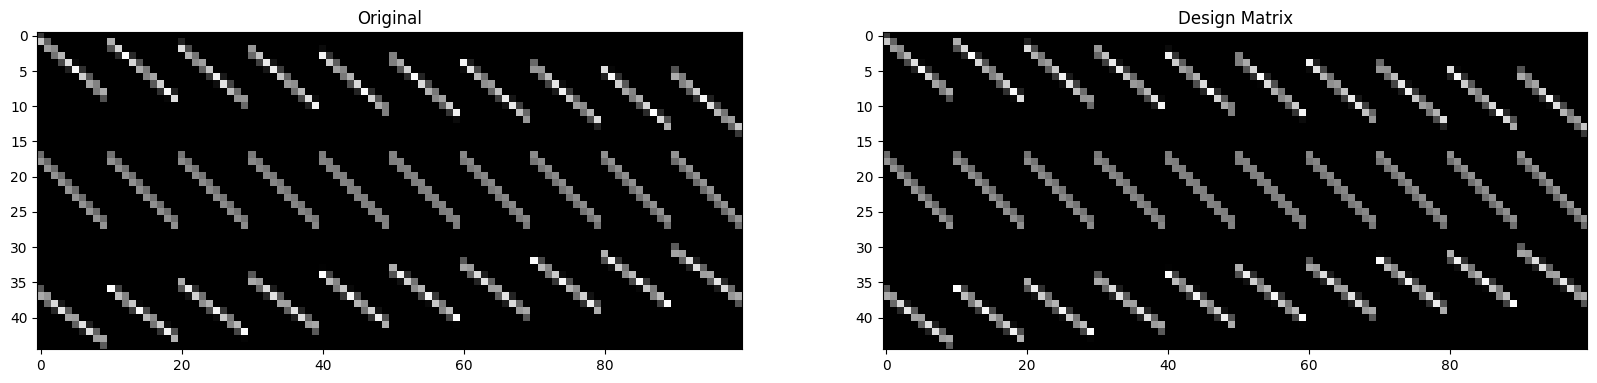

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(design_matrix, cmap='gray')
ax[1].set_title('Design Matrix')
plt.show()

#### Task 2

In [8]:
M = 77 ## 195

## load the data
data_path = "../data/"

if M == 77:
    alphas = np.load(data_path + "alphas_77.npy",allow_pickle=True)
    y = np.load(data_path + "y_77.npy",allow_pickle=True)
    X = np.load(data_path + "X_77.npy",allow_pickle=True)
    X = scipy.sparse.csc_matrix(X.all())
else:
    alphas = np.load(data_path + "alphas_195.npy",allow_pickle=True)
    y = np.load(data_path + "y_195.npy",allow_pickle=True)
    # X = np.load(data_path + "X.npy",allow_pickle=True)


print(scipy.sparse.issparse(X))
print("Indices of non zero elements:",scipy.sparse.find(X)[0],scipy.sparse.find(X)[1])
print("Number of non zero elements:",X.nnz)
print("Sparsity measure:",X.nnz/(X.shape[0]*X.shape[1]))

True
Indices of non zero elements: [  15   16  123 ... 9611 9717 9718] [   0    0    0 ... 5928 5928 5928]
Number of non zero elements: 1066978
Sparsity measure: 0.01834446316753001


In [9]:
print(X.shape,design_matrix.shape)
design_matrix = construct_X(M, alphas, Np=None)
design_matrix = scipy.sparse.csc_matrix(design_matrix)
print(type(design_matrix),type(X))

(9810, 5929) (45, 100)
<class 'scipy.sparse._csc.csc_matrix'> <class 'scipy.sparse._csc.csc_matrix'>


(5929,)


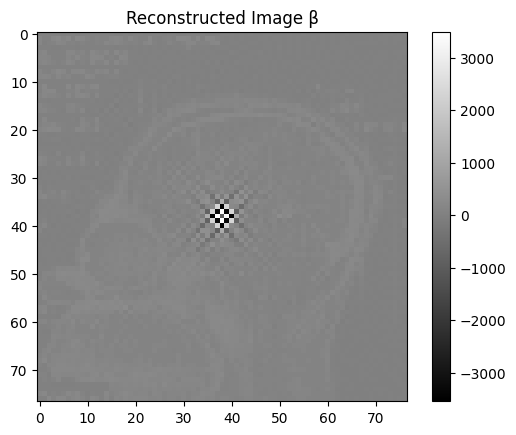

In [10]:
result = scipy.sparse.linalg.lsqr(design_matrix, y)
beta = result[0]
print(beta.shape)
M = 77
beta = beta.reshape(M,M)

# Visualize the reconstructed image
plt.imshow(beta, cmap='gray')
plt.title('Reconstructed Image β')
plt.colorbar()
plt.show()

#### Task 3

In [11]:
## empiricaly I can determine a lower number of alpha, but what would be an analytical optimum

def subsample_projections(alphas, y, num_projections):
    indices = np.linspace(0, len(alphas) - 1, num_projections, dtype=int)
    return alphas[indices], y[indices]

def reconstruct_image(alphas, y, num_projections, M, Np):
    # Subsample the projections
    alphas_sub, y_sub = subsample_projections(alphas, y, num_projections)
    
    # Construct the matrix X for the subsampled angles (this is a placeholder, actual construction of X will depend on specific implementation)
    X_sub = construct_X(M, alphas_sub)  # This function needs to be defined based on your specific implementation
    
    # Convert to sparse matrix
    X_sparse_sub = scipy.sparse.csc_matrix(X_sub)
    
    # Solve the least-squares problem
    result = scipy.sparse.lsqr(X_sparse_sub, y_sub)
    beta = result[0]
    
    # Reshape beta to the appropriate image dimensions
    beta_image = beta.reshape((M,M))
    
    return beta_image

AttributeError: module 'scipy.sparse' has no attribute 'lsqr'

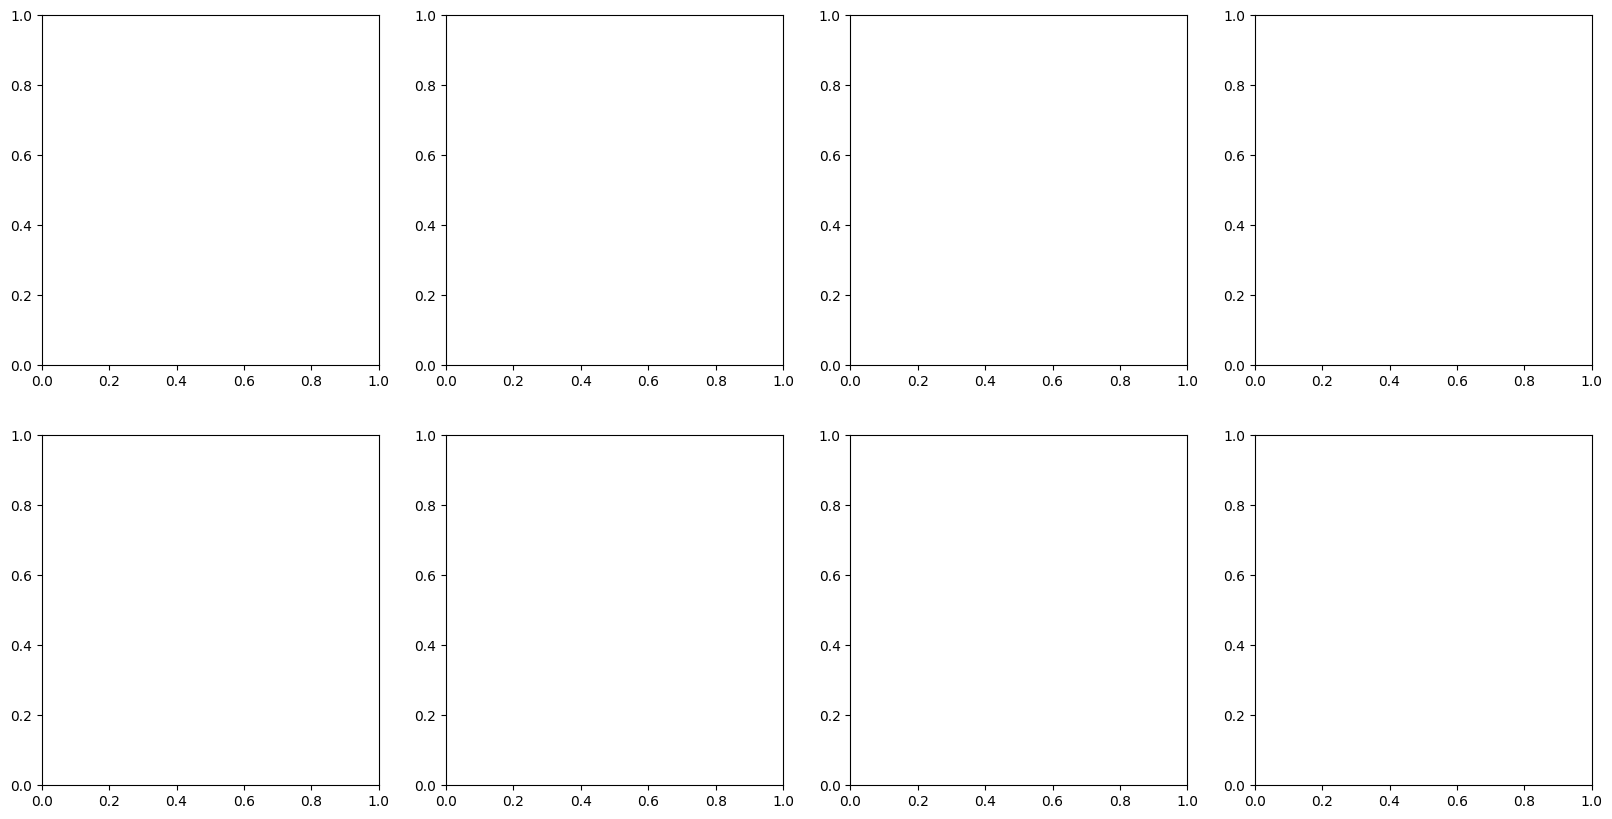

In [12]:
M = 77
Np = 109
num_projections_list = [10, 20, 30, 40, 50, 60, 70, 77]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, num_projections in enumerate(num_projections_list):
    beta_image = reconstruct_image(alphas, y, num_projections, M, Np)
    ax = axes[i // 4, i % 4]
    ax.imshow(beta_image, cmap='gray')
    ax.set_title(f'{num_projections} projections')
    ax.axis('off')

plt.tight_layout()
plt.show()
